In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import sys
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import glob
from typing import List, Optional, Any
from PIL import Image
from math import log2
from collections import defaultdict, Counter

Mounted at /content/drive


                                          customer_id  \
0   efaafb08a00e63ce561a67c31c1ab7e720d4f394a78c47...   
1   6980555e2eaa19a3f9f8df02e983a8e50abddf6e49cc63...   
2   788785852eddb5874f924603105f315d69571b3e5180f3...   
3   e2731ecc3fb093e25d17348a02a34124c05cd960e9ebd3...   
4   3e8272741c39b3579424da34b2c8b752d2cce5010774d5...   
5   0a45168a9fdde35557e23ab2663ffbd0d565ac380ece7a...   
6   d8c54f5ca6421ba8c5d7631ebdf7a5b67ccf2dce4b859c...   
7   eeff2435dc9b9c1ce597bec9b0266ef4447660800c2a3e...   
8   b174ec45ce78c132071d8267979596ef8eeaf2eeee0e7f...   
9   49841603f3cacf4e7275219dbda875c1226be364466887...   
10  ded9357d33fef6bb884ccb50a40840c4c2d4a27a444b80...   
11  1f5dc0b0f41070e49f55c465318791158aec6dd85b94eb...   
12  d193376eabb7659334edf3536f023197785b321a05774d...   
13  75d3fd5c788fd6f89abdc383ebb5bff31865c830f95008...   
14  49b9854698ccf618a463f0ccfb71288a554062fd42c2ee...   
15  5e03e34f49be37b5166d11775e5fc9e85dfcabe18b48c9...   
16  da0e21de6910c1b9127f867c990

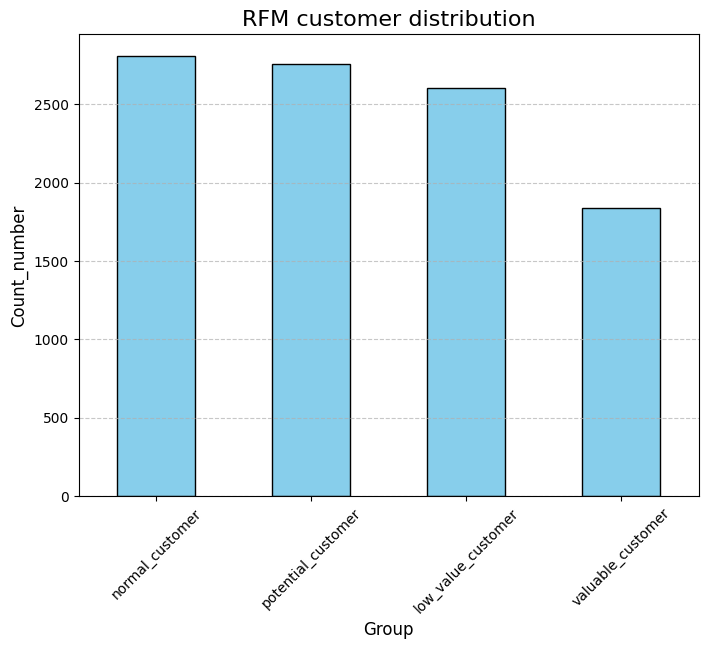

In [2]:
""" Data Management to group different customers. """

input_path = '/content/drive/MyDrive/dissertation/10000_transactions_subset_customers_after20200721_ge6.csv'

df = pd.read_csv(input_path)

grouped_df = (
    df.groupby('customer_id')['article_id']
    .agg([lambda x: ','.join(x.astype(str)),
          'count'])
    .reset_index()
)

grouped_df.columns = ['customer_id', 'article_ids', 'purchase_count']
grouped_df = grouped_df.sort_values(by='purchase_count', ascending=False)

repeat_df = (
    df.groupby(['customer_id', 'article_id'])
    .size()
    .reset_index(name='count')
)

repeat_df = repeat_df[repeat_df['count'] > 5] #repeat purchase > 5

repeat_articles = (
    repeat_df.groupby('customer_id')['article_id']
    .apply(lambda x: ','.join(x.astype(str)))
    .reset_index()
    .rename(columns={'article_id': 'repeated_article_ids'})
)

final_df = grouped_df.merge(repeat_articles, on='customer_id', how='left')

final_df['repeated_article_ids'] = final_df['repeated_article_ids'].fillna('')

total_spent_df = (
    df.groupby('customer_id')['price']
    .sum()
    .reset_index()
    .rename(columns={'price': 'total_spent'})
)

final_df = final_df.merge(total_spent_df, on='customer_id', how='left')

print(final_df.head(20))

df['t_dat'] = pd.to_datetime(df['t_dat'], format='%Y-%m-%d')

analysis_date = df['t_dat'].max() + pd.Timedelta(days=1)

# compute RFM model score:
rfm_df = df.groupby('customer_id').agg({
    't_dat': lambda x: (analysis_date - x.max()).days,  # R: the last day purchased
    'customer_id': 'count',                             # F: how many time purchase
    'price': 'sum'                                      # M: total spent money
}).rename(columns={
    't_dat': 'Recency',
    'customer_id': 'Frequency',
    'price': 'Monetary'
}).reset_index()

rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5,4,3,2,1])
rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1,2,3,4,5])

rfm_df['RFM_score'] = rfm_df['R_score'].astype(int) + rfm_df['F_score'].astype(int) + rfm_df['M_score'].astype(int)

# print(rfm_df.head(20))

def rfm_segment(row):
    if row['RFM_score'] >= 13:
        return 'valuable_customer'
    elif row['RFM_score'] >= 10:
        return 'potential_customer'
    elif row['RFM_score'] >= 7:
        return 'normal_customer'
    else:
        return 'low_value_customer'

rfm_df['Segment'] = rfm_df.apply(rfm_segment, axis=1)

segment_counts = rfm_df['Segment'].value_counts()

plt.figure(figsize=(8, 6))
segment_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('RFM customer distribution', fontsize=16)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Count_number', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [3]:
df['t_dat'] = pd.to_datetime(df['t_dat'], errors='coerce')

# group customer-article, and the last time to purchase a product
cust_prod_stats = (
    df.groupby(['customer_id','article_id'])
      .agg(
          purchase_count=('article_id','size'),
          last_purchase_date=('t_dat','max')
      )
      .reset_index()
)

repeat_purchases = cust_prod_stats[cust_prod_stats['purchase_count'] >= 2]

# the last time a repeat top 1 product been purchased
repeat_top1 = (
    repeat_purchases
    .sort_values(['customer_id','purchase_count','last_purchase_date'], ascending=[True,False,False])
    .drop_duplicates(subset=['customer_id'], keep='first')
    .rename(columns={'article_id':'top_repeated_article',
                     'last_purchase_date':'last_repeat_date'})
)

final_df_sorted = final_df.merge(repeat_top1[['customer_id','top_repeated_article','last_repeat_date']],
                                 on='customer_id', how='left')

for _, row in final_df_sorted.head(10).iterrows():
    if pd.notna(row['top_repeated_article']):
        article_str = str(int(row['top_repeated_article'])) if float(row['top_repeated_article']).is_integer() else str(row['top_repeated_article'])
        print(f"Customer {row['customer_id']} | Total_spent={row['total_spent']:.2f} | "
              f"Repeated article={article_str} | "
              f"Last repeat date={row['last_repeat_date'].date()}")
    else:
        print(f"Customer {row['customer_id']} | Total_spent={row['total_spent']:.2f} | No repeated articles")



Customer efaafb08a00e63ce561a67c31c1ab7e720d4f394a78c4705518dc02084a29172 | Total_spent=34.19 | Repeated article=678687001 | Last repeat date=2019-12-20
Customer 6980555e2eaa19a3f9f8df02e983a8e50abddf6e49cc6310ee45cce60284b62f | Total_spent=35.86 | Repeated article=658030017 | Last repeat date=2020-02-01
Customer 788785852eddb5874f924603105f315d69571b3e5180f3a7ae6970b55b6d5dc9 | Total_spent=29.78 | Repeated article=843272002 | Last repeat date=2020-06-24
Customer e2731ecc3fb093e25d17348a02a34124c05cd960e9ebd34ea4571970c4e626bd | Total_spent=26.20 | Repeated article=788176001 | Last repeat date=2019-11-28
Customer 3e8272741c39b3579424da34b2c8b752d2cce5010774d52eb0eee7ce81f6103e | Total_spent=32.10 | Repeated article=890450001 | Last repeat date=2020-07-17
Customer 0a45168a9fdde35557e23ab2663ffbd0d565ac380ece7a3b09e7680c2a0f94be | Total_spent=25.69 | Repeated article=747373001 | Last repeat date=2019-02-12
Customer d8c54f5ca6421ba8c5d7631ebdf7a5b67ccf2dce4b859caa7092be3c8b3e261a | Total_

In [4]:
"""
Feature one: recommend items from the repeat purchase, if there is no repeat purchase,
recommend item from just purchased items.
It's the simplest recommendation system.
"""

RANDOM_STATE = 42

repeat_df_clean = repeat_df.dropna(subset=['article_id']).copy()
df_clean = df.dropna(subset=['article_id']).copy()


# select the most repeat product
rec_from_repeats = (
    repeat_df_clean
    .sort_values(['customer_id','count'], ascending=[True, False])
    .drop_duplicates(subset=['customer_id'], keep='first')
    .set_index('customer_id')['article_id']
)

final_df['recommended_article_id'] = final_df['customer_id'].map(rec_from_repeats)

# select one purchased item, in case there is no repeat purchase
fallback_any = (
    df_clean.groupby('customer_id')['article_id']
    .apply(lambda s: s.sample(1, random_state=RANDOM_STATE).iloc[0])
)

final_df['recommended_article_id'] = final_df['recommended_article_id'].fillna(
    final_df['customer_id'].map(fallback_any)
)

# mark the recommendation from repeat or fallback
final_df['recommendation_source'] = np.where(
    final_df['customer_id'].isin(rec_from_repeats.index), 'repeat', 'fallback'
)

final_df['recommended_article_id'] = (
    final_df['recommended_article_id']
    .astype(str)
    .str.replace(r'\.0$','',regex=True)
)

for _, row in final_df.head(5).iterrows():
    print(f"for customer {row['customer_id']} recommend the article_id: {row['recommended_article_id']} ")


for customer efaafb08a00e63ce561a67c31c1ab7e720d4f394a78c4705518dc02084a29172 recommend the article_id: 678687001 
for customer 6980555e2eaa19a3f9f8df02e983a8e50abddf6e49cc6310ee45cce60284b62f recommend the article_id: 850643001 
for customer 788785852eddb5874f924603105f315d69571b3e5180f3a7ae6970b55b6d5dc9 recommend the article_id: 902229004 
for customer e2731ecc3fb093e25d17348a02a34124c05cd960e9ebd34ea4571970c4e626bd recommend the article_id: 788176001 
for customer 3e8272741c39b3579424da34b2c8b752d2cce5010774d52eb0eee7ce81f6103e recommend the article_id: 701735009 


In [5]:
"""
Feature two: recommend items from the purchase history of a customer, vector the atrribute of a product,
then find the similarity from the product list, which this product a customer never bought before.
It's a little bit tricky one recommendation, but I think now works ok.
"""

transactions = pd.read_csv('/content/drive/MyDrive/dissertation/10000_transactions_subset_customers_after20200721_ge6.csv')
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

articles = pd.read_csv('/content/drive/MyDrive/dissertation/articles.csv')
# Link the articles.csv

df = transactions.merge(articles, on='article_id', how='left')

# Text featuring
df['item_text'] = (
    df['product_type_name'].fillna('') + ' ' +
    df['colour_group_name'].fillna('') + ' ' +
    df['product_group_name'].fillna('') + ' ' +
    df['graphical_appearance_name'].fillna('')
)

items = df.drop_duplicates('article_id', keep='first')[['article_id', 'item_text']].reset_index(drop=True)

# Make the product into vector
vectorizer = CountVectorizer()
item_features = vectorizer.fit_transform(items['item_text'])

# Listing customer-purchased items
user_groups = df.groupby('customer_id')['article_id'].apply(set).to_dict()

aid2idx = {aid: i for i, aid in enumerate(items['article_id'].tolist())}
idx2aid = {i: aid for aid, i in aid2idx.items()}

def recommend_for_user(user_id, top_n=2, return_scores=False):
    if user_id not in user_groups:
        return []

    purchased = user_groups[user_id]

    purchased_indices = [aid2idx[aid] for aid in purchased if aid in aid2idx]
    if not purchased_indices:
        return []

    # Picturing customer
    user_profile = item_features[purchased_indices].mean(axis=0)
    user_profile = np.asarray(user_profile).reshape(1, -1)

    # Find the similar products, according to the UNIQUE product previously
    sims = cosine_similarity(user_profile, item_features).ravel()

    # Recommend the product that a customer have not bought
    candidate_indices = [i for i, aid in enumerate(items['article_id']) if aid not in purchased]
    if not candidate_indices:
        return []

    candidate_scores = [(i, sims[i]) for i in candidate_indices]
    candidate_scores.sort(key=lambda x: x[1], reverse=True)
    top = candidate_scores[:top_n]

    if return_scores:
        return [(idx2aid[i], score) for i, score in top]
    else:
        return [idx2aid[i] for i, _ in top]

top_users = final_df['customer_id'].drop_duplicates().head(5).tolist()
rows = []
top_n = 2

for uid in top_users:
  recs = recommend_for_user(uid, top_n=top_n, return_scores=True)
  for rank, (aid, score) in enumerate(recs, start=1):
    rows.append({
        'customer_id': uid,
        'article_id': aid,
        'rank': rank,
        'similarity': float(score)
    })

reco_df = pd.DataFrame(rows).sort_values(['customer_id','rank'])
# print("The top 5 customers recommendation, 2 products: ")
# print(reco_df.head(25))

for uid in top_users:
    grp = reco_df[reco_df['customer_id'] == uid]
    print(f"\nUser: {uid}")
    for _, row in grp.iterrows():
        print(f"  #{int(row['rank'])}: article_id={row['article_id']}  (similarity={row['similarity']:.4f})")



User: efaafb08a00e63ce561a67c31c1ab7e720d4f394a78c4705518dc02084a29172
  #1: article_id=573716012  (similarity=0.8271)
  #2: article_id=578476001  (similarity=0.8271)

User: 6980555e2eaa19a3f9f8df02e983a8e50abddf6e49cc6310ee45cce60284b62f
  #1: article_id=622192001  (similarity=0.8113)
  #2: article_id=522398011  (similarity=0.8113)

User: 788785852eddb5874f924603105f315d69571b3e5180f3a7ae6970b55b6d5dc9
  #1: article_id=676352001  (similarity=0.8417)
  #2: article_id=577314002  (similarity=0.8417)

User: e2731ecc3fb093e25d17348a02a34124c05cd960e9ebd34ea4571970c4e626bd
  #1: article_id=620625001  (similarity=0.8904)
  #2: article_id=688873001  (similarity=0.8904)

User: 3e8272741c39b3579424da34b2c8b752d2cce5010774d52eb0eee7ce81f6103e
  #1: article_id=678065001  (similarity=0.8692)
  #2: article_id=662728004  (similarity=0.8692)


In [6]:
"""
Feature three: sequential recommendation sys, mark decay from the lastest to the firstest.
"""

transactions = pd.read_csv('/content/drive/MyDrive/dissertation/10000_transactions_subset_customers_after20200721_ge6.csv')
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

articles = pd.read_csv('/content/drive/MyDrive/dissertation/articles.csv')
df = transactions.merge(articles, on='article_id', how='left')

df = df.sort_values(['customer_id', 't_dat', 'article_id'])
df['article_id'] = df['article_id'].astype(str)

customer_purchase_count = (
    df.groupby('customer_id',as_index=False)['article_id']
      .count()
      .rename(columns={'article_id': 'purchase_count'})
      .sort_values('purchase_count', ascending=False)
)

top_users = customer_purchase_count['customer_id'].head(5).tolist()
order_map = {uid: i for i, uid in enumerate(top_users)}

user_sequences = (
    df.groupby('customer_id')['article_id']
      .apply(list)
      .to_dict()
)

transitions = defaultdict(Counter)
for uid, seq in user_sequences.items():
    for a, b in zip(seq, seq[1:]):
        if a != b:
            transitions[a][b] += 1

transition_prob = {}
for a, counter in transitions.items():
    total = sum(counter.values())
    transition_prob[a] = {b: cnt/total for b, cnt in counter.items()} if total > 0 else {}

global_next_counter = Counter()
for a, counter in transitions.items():
    global_next_counter.update(counter)
total_global = sum(global_next_counter.values())
global_next_prob = {b: c/total_global for b, c in global_next_counter.items()} if total_global > 0 else {}

user_purchased_set = {uid: set(seq) for uid, seq in user_sequences.items()}

def recommend_for_user_seq(user_id, top_n=3, lookback=3, decay=0.7, exclude_bought=True, return_scores=True):
    if user_id not in user_sequences or not user_sequences[user_id]:
        return []

    seq = user_sequences[user_id]
    recent_items = seq[-lookback:] if len(seq) >= lookback else seq[:]
    weights = [decay ** i for i in range(len(recent_items))]
    weights = weights[::-1]

    scores = Counter()
    for a, w in zip(recent_items, weights):
        next_dict = transition_prob.get(a)
        if not next_dict:
            for b, p in global_next_prob.items():
                scores[b] += w * p
        else:
            for b, p in next_dict.items():
                scores[b] += w * p

    if exclude_bought:
        for b in list(scores.keys()):
            if b in user_purchased_set.get(user_id, set()):
                del scores[b]

    if not scores:
        return []

    ranked = scores.most_common(top_n)
    return [(aid, float(score)) for aid, score in ranked] if return_scores else [aid for aid, _ in ranked]

rows = []
TOP_N = 3

for uid in top_users:
    recs = recommend_for_user_seq(uid, top_n=TOP_N, lookback=3, decay=0.7, exclude_bought=True, return_scores=True)
    for rank, (aid, score) in enumerate(recs, start=1):
        rows.append({
            'customer_id': uid,
            'article_id': aid,
            'rank': rank,
            'score': score
        })

reco_df = pd.DataFrame(rows)
reco_df['spend_order'] = reco_df['customer_id'].map(order_map)
reco_df = reco_df.sort_values(['spend_order', 'rank']).drop(columns=['spend_order'])

for uid in top_users:
    grp = reco_df[reco_df['customer_id'] == uid]
    print(f"\nUser: {uid}")
    if grp.empty:
        print("  (No recommendation candidates)")
        continue
    for _, row in grp.iterrows():
        print(f"  #{int(row['rank'])}: article_id={row['article_id']}  (score={row['score']:.6f})")



User: efaafb08a00e63ce561a67c31c1ab7e720d4f394a78c4705518dc02084a29172
  #1: article_id=857778011  (score=0.127273)
  #2: article_id=805000001  (score=0.112522)
  #3: article_id=794575001  (score=0.089952)

User: 6980555e2eaa19a3f9f8df02e983a8e50abddf6e49cc6310ee45cce60284b62f
  #1: article_id=896152003  (score=1.000000)
  #2: article_id=935689001  (score=0.320833)
  #3: article_id=935092001  (score=0.058333)

User: 788785852eddb5874f924603105f315d69571b3e5180f3a7ae6970b55b6d5dc9
  #1: article_id=811783005  (score=0.850000)
  #2: article_id=924877002  (score=0.850000)

User: e2731ecc3fb093e25d17348a02a34124c05cd960e9ebd34ea4571970c4e626bd
  #1: article_id=933032001  (score=0.100000)
  #2: article_id=933989001  (score=0.057903)
  #3: article_id=716672001  (score=0.050000)

User: 3e8272741c39b3579424da34b2c8b752d2cce5010774d52eb0eee7ce81f6103e
  #1: article_id=903926002  (score=0.350000)
  #2: article_id=921298003  (score=0.200000)
  #3: article_id=915985001  (score=0.200000)


In [7]:
def describe_user_profile(user_id, top_k=15):
    purchased = user_groups.get(user_id, set())
    purchased_indices = [aid2idx[aid] for aid in purchased if aid in aid2idx]
    if not purchased_indices:
        return "No enough data to generate a profile."

    user_profile = item_features[purchased_indices].mean(axis=0)
    user_profile = np.asarray(user_profile).ravel()

    top_idx = np.argsort(-user_profile)[:top_k]
    vocab_sorted = np.array(sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1]))[:,0]
    top_terms = vocab_sorted[top_idx]

    colors = []
    categories = []
    styles = []
    for term in top_terms:
        t = term.lower()
        if t in ['black', 'beige', 'light', 'white', 'blue', 'red']:
            colors.append(term)
        elif t in ['dress', 'blouse', 'tights', 'lingerie', 'lingeries', 'underwear', 'bottom', 'knitwear', 'jersey']:
            categories.append(term)
        else:
            styles.append(term)

    desc = []
    if categories:
        desc.append(f"for the categories this customer prefers {', '.join(categories)} ;")
    if colors:
        desc.append(f"for the colours this customer prefers {', '.join(colors)} ;")
    if styles:
        desc.append(f"for the styles/attributes this customer prefers {', '.join(styles)}")
    if not desc:
      return "No clear preferences detected."

    return "In general, \n" + "\n".join(desc) + "."

if 'final_df' in globals():
  top_users = final_df['customer_id'].drop_duplicates().head(5).tolist()
else:
  top_users = df['customer_id'].drop_duplicates().head(5).tolist()

TOP_N = 5
for uid in top_users:
    recs = recommend_for_user(uid, top_n=TOP_N, return_scores=True)
    # print(f"Customer {uid}, the recommendations are (with similarity):")
    # for rank, (aid, score) in enumerate(recs, start=1):
    #     print(f"    #{rank}: article_id={aid}  (similarity={float(score):.4f})")

sample_user = (
    final_df['customer_id'].drop_duplicates().iloc[1]
    if 'final_df' in globals()
    else df['customer_id'].drop_duplicates().iloc[1]
)
# print(f"For this customer {sample_user}, the recommendation are: ", recommend_for_user(sample_user, top_n=5))
print(f"\nCustomer {sample_user} portrait:")
print(describe_user_profile(sample_user))



Customer 6980555e2eaa19a3f9f8df02e983a8e50abddf6e49cc6310ee45cce60284b62f portrait:
In general, 
for the categories this customer prefers dress ;
for the colours this customer prefers black, white, light, beige ;
for the styles/attributes this customer prefers body, garment, solid, upper, full, lower, swimwear, pattern, all, over.


In [8]:
"""
Put the feature one, feature two and feature three recommendation list together.
"""

def _normalize_aid(a):
    if a is None or (isinstance(a, float) and np.isnan(a)):
        return None
    s = str(a)
    if s.endswith('.0'):
        s = s[:-2]
    return s

# feature one map (repeat/fallback)
rec1_map = (
    final_df[['customer_id', 'recommended_article_id']]
    .drop_duplicates(subset=['customer_id'])
    .assign(recommended_article_id=lambda d: d['recommended_article_id'].apply(_normalize_aid))
    .set_index('customer_id')['recommended_article_id']
    .to_dict()
)

users = final_df['customer_id'].drop_duplicates().tolist()
rows = []

for uid in users:
    r1 = rec1_map.get(uid, None)

    # feature two: content-based
    try:
        recs2 = recommend_for_user(uid, top_n=2, return_scores=False)
    except Exception:
        recs2 = []
    recs2 = [_normalize_aid(x) for x in (recs2 or []) if x is not None]

    # feature three: sequential
    try:
        recs3 = recommend_for_user_seq(uid, top_n=3, lookback=3, decay=0.7, exclude_bought=True, return_scores=False)
    except Exception:
        recs3 = []
    recs3 = [_normalize_aid(x) for x in (recs3 or []) if x is not None]

    # merge with de-dup, keep order: r1 -> recs2 -> recs3
    combined = []
    if r1 is not None:
        combined.append(r1)
    for a in recs2:
        if a and a not in combined:
            combined.append(a)
        if len(combined) >= 6:
            break
    if len(combined) < 6:
        for a in recs3:
            if a and a not in combined:
                combined.append(a)
            if len(combined) >= 6:
                break

    while len(combined) < 6:
        combined.append(None)

    rows.append({
        'customer_id': uid,
        'rec_1': combined[0],
        'rec_2': combined[1],
        'rec_3': combined[2],
        'rec_4': combined[3],
        'rec_5': combined[4],
        'rec_6': combined[5],
    })

merged_reco_df = pd.DataFrame(rows)

print("Merged (wide) recommendations preview:")
print(merged_reco_df.head(10))


Merged (wide) recommendations preview:
                                         customer_id      rec_1      rec_2  \
0  efaafb08a00e63ce561a67c31c1ab7e720d4f394a78c47...  678687001  573716012   
1  6980555e2eaa19a3f9f8df02e983a8e50abddf6e49cc63...  850643001  622192001   
2  788785852eddb5874f924603105f315d69571b3e5180f3...  902229004  676352001   
3  e2731ecc3fb093e25d17348a02a34124c05cd960e9ebd3...  788176001  620625001   
4  3e8272741c39b3579424da34b2c8b752d2cce5010774d5...  701735009  678065001   
5  0a45168a9fdde35557e23ab2663ffbd0d565ac380ece7a...  747373001  622192001   
6  d8c54f5ca6421ba8c5d7631ebdf7a5b67ccf2dce4b859c...  767893001  573716012   
7  eeff2435dc9b9c1ce597bec9b0266ef4447660800c2a3e...  753802004  622192001   
8  b174ec45ce78c132071d8267979596ef8eeaf2eeee0e7f...  788578001  515991007   
9  49841603f3cacf4e7275219dbda875c1226be364466887...  677999001  622192001   

       rec_3      rec_4      rec_5      rec_6  
0  578476001  857778011  805000001  794575001  
1  522

The customer efaafb08a00e63ce561a67c31c1ab7e720d4f394a78c4705518dc02084a29172, the recommended article_ids:  [['678687001', '573716012', '578476001', '857778011', '805000001', '794575001']]


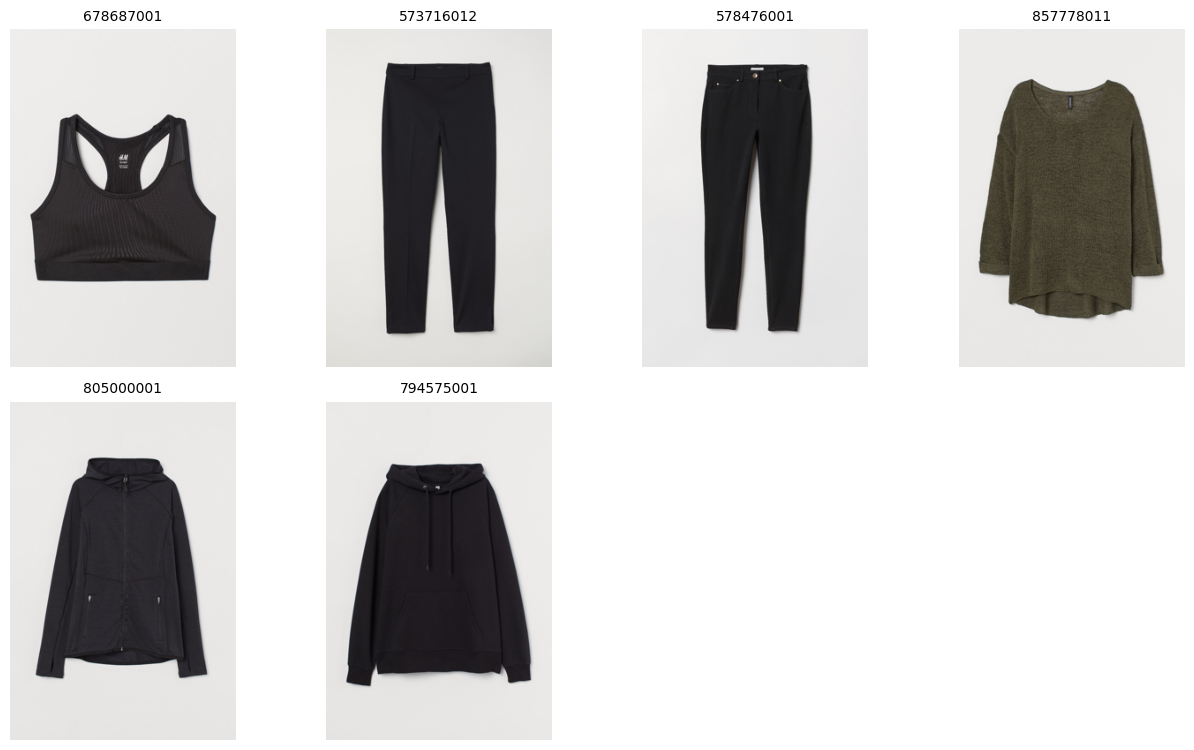

Images saved: /content/drive/MyDrive/dissertation/figs/reco_contact_sheet_first_user.jpg


In [9]:
"""Match the recommendations list with the product picture library."""

def _norm_id_str(a: Any) -> Optional[str]:
    if a is None:
        return None
    if isinstance(a, float) and (np.isnan(a) or not np.isfinite(a)):
        return None
    s = str(a).strip()
    if s.endswith(".0"):
        s = s[:-2]
    return s or None


IMAGE_DIR = "/content/drive/MyDrive/dissertation/collected_images"
IMAGE_MAP_CSV = None

image_map = None
if IMAGE_MAP_CSV and os.path.exists(IMAGE_MAP_CSV):
    _map_df = pd.read_csv(IMAGE_MAP_CSV)
    _map_df["article_id_norm"] = _map_df["article_id"].apply(_norm_id_str)
    image_map = dict(zip(_map_df["article_id_norm"], _map_df["image_path"]))

def find_image_path(article_id: Any) -> Optional[str]:
    aid_str = _norm_id_str(article_id)
    if aid_str is None:
        return None

    if image_map is not None:
        p = image_map.get(aid_str)
        if p:
            if os.path.isabs(p) and os.path.exists(p):
                return p
            cand = p if os.path.isabs(p) else os.path.join(IMAGE_DIR, p)
            if os.path.exists(cand):
                return cand

    exts = ["jpg", "jpeg", "png", "webp"]
    for ext in exts:
        cand = os.path.join(IMAGE_DIR, f"{aid_str}.{ext}")
        if os.path.exists(cand):
            return cand

    patterns = [f"*{aid_str}*.{e}" for e in exts]
    for pat in patterns:
        matches = glob.glob(os.path.join(IMAGE_DIR, pat))
        if matches:
            return matches[0]

    return None

def show_recommendation_images(
    user_id,
    top_n=6,
    cols=4,
    thumb_max_size=384,
    save_contact_sheet=None,
    rec_source="merged",
):
    article_ids = []
    if rec_source == "merged" and "merged_reco_df" in globals():
        row = merged_reco_df.loc[merged_reco_df["customer_id"] == user_id]
        if not row.empty:
            rec_cols = [c for c in row.columns if c.startswith("rec_")]
            rec_cols = sorted(rec_cols, key=lambda x: int(x.split("_")[1]))
            article_ids = row.iloc[0][rec_cols].tolist()
            article_ids = [a for a in article_ids if a is not None][:top_n]
    if not article_ids:
        try:
            article_ids = recommend_for_user(user_id, top_n=top_n)
        except Exception:
            article_ids = []

    if not article_ids:
        print("No recommendation.")
        return

    images, labels, missing = [], [], []
    for aid in article_ids:
        p = find_image_path(aid)
        if p is None:
            missing.append(_norm_id_str(aid))
            continue
        try:
            img = Image.open(p).convert("RGB")
            img.thumbnail((thumb_max_size, thumb_max_size))
            images.append(img)
            labels.append(_norm_id_str(aid))
        except Exception as e:
            print(f"Fail to open the image. {aid}: {e}")
            missing.append(_norm_id_str(aid))

    if missing:
        print(f"Cannot find the pictures for: {missing}")

    if not images:
        print("Cannot load images.")
        return

    cols = max(1, cols)
    rows_n = int(np.ceil(len(images) / cols))
    fig_w = cols * 3.2
    fig_h = rows_n * 3.8
    plt.figure(figsize=(fig_w, fig_h))
    for i, img in enumerate(images):
        ax = plt.subplot(rows_n, cols, i + 1)
        ax.imshow(img)
        ax.set_title(labels[i] or "", fontsize=10)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

    if save_contact_sheet:
        cell_w = max(img.width for img in images)
        cell_h = max(img.height for img in images)
        sheet = Image.new("RGB", (cell_w * cols, cell_h * rows_n), (255, 255, 255))
        for idx, img in enumerate(images):
            r = idx // cols
            c = idx % cols
            x = c * cell_w + (cell_w - img.width) // 2
            y = r * cell_h + (cell_h - img.height) // 2
            sheet.paste(img, (x, y))
        os.makedirs(os.path.dirname(save_contact_sheet), exist_ok=True)
        sheet.save(save_contact_sheet, quality=90)
        print(f"Images saved: {save_contact_sheet}")

first_user = (
    final_df["customer_id"].drop_duplicates().iloc[0]
    if "final_df" in globals()
    else df["customer_id"].drop_duplicates().iloc[0]
)
print(
    f"The customer {first_user}, the recommended article_ids: ",
    merged_reco_df.loc[merged_reco_df["customer_id"]==first_user, ["rec_1","rec_2","rec_3","rec_4","rec_5","rec_6"]].values.tolist()
)

show_recommendation_images(
    first_user,
    top_n=6,
    cols=4,
    thumb_max_size=384,
    save_contact_sheet="/content/drive/MyDrive/dissertation/figs/reco_contact_sheet_first_user.jpg",
    rec_source="merged",
)


In [10]:
"""
Evaluation part, three metrics are calculated: Precise, Recall, MAP@6, but the current
results are still not very satisfactory.

The offline evaluation methods have many limitations, online evaluation are essential
in real business environment.
"""
CUTOFF_DATE = "2020-07-21"
K = 6
EXCLUDE_SEEN = True
REQUIRE_TRAIN_AND_TEST = True


if 'df' not in globals():
    raise RuntimeError("Variable df not exist")
if 'merged_reco_df' not in globals():
    raise RuntimeError("Variable merged_reco_df not exist")

need = {'customer_id','article_id','t_dat'}
miss = need - set(df.columns)
if miss:
    raise RuntimeError(f"df lack of attributes: {miss}")

def _norm_aid(a):
    if a is None or (isinstance(a, float) and np.isnan(a)):
        return None
    s = str(a)
    return s[:-2] if s.endswith('.0') else s

def _average_precision_at_k(hit_flags):
    """AP@K: average the precision position."""
    hits, ap = 0, 0.0
    denom = max(1, sum(hit_flags))
    for i, h in enumerate(hit_flags, start=1):
        if h:
            hits += 1
            ap += hits / i
    return ap / denom

df_eval = df.copy()

if not np.issubdtype(df_eval['t_dat'].dtype, np.datetime64):
    df_eval['t_dat'] = pd.to_datetime(df_eval['t_dat'], errors='coerce')

df_eval = df_eval.dropna(subset=['customer_id','article_id','t_dat'])

df_eval['_aid'] = df_eval['article_id'].apply(_norm_aid)
df_eval = df_eval.dropna(subset=['_aid'])

cutoff_ts = pd.to_datetime(CUTOFF_DATE)
train_df = df_eval[df_eval['t_dat'] < cutoff_ts]
test_df  = df_eval[df_eval['t_dat'] >= cutoff_ts]

gt_map = test_df.groupby('customer_id')['_aid'].apply(lambda s: set(s)).to_dict()
seen_map = train_df.groupby('customer_id')['_aid'].apply(lambda s: set(s)).to_dict()

rec_cols = [c for c in merged_reco_df.columns if c.startswith('rec_')]
if not rec_cols:
    raise RuntimeError("no recommendation list in merged_reco_df")

pred_map = {}
for _, r in merged_reco_df[['customer_id'] + rec_cols].drop_duplicates('customer_id').iterrows():
    uid = r['customer_id']
    raw = [_norm_aid(r[c]) for c in rec_cols]
    cleaned, seen = [], set()
    for a in raw:
        if a and a not in seen:
            seen.add(a); cleaned.append(a)
    pred_map[uid] = cleaned[:K]

users_test  = set(gt_map.keys())
users_train = set(seen_map.keys())
users_pred  = set(pred_map.keys())

if REQUIRE_TRAIN_AND_TEST:
    users_eval = sorted(list(users_test & users_train & users_pred))
else:
    users_eval = sorted(list(users_test & users_pred))

precisions, recalls, aps = [], [], []
for uid in users_eval:
    gt_set = gt_map.get(uid, set())
    if not gt_set:
        continue

    preds = pred_map.get(uid, [])

    if EXCLUDE_SEEN:
        preds = [a for a in preds if a not in seen_map.get(uid, set())]

    if not preds:
        continue

    preds = preds[:K]

    hit_flags = [1 if a in gt_set else 0 for a in preds]
    hits = sum(hit_flags)
    effective_k = max(1, min(K, len(preds)))
    precisions.append(hits / effective_k)

    recalls.append(hits / len(gt_set))

    aps.append(_average_precision_at_k(hit_flags))

results = {
    f'Precision@{K}': float(np.mean(precisions)) if precisions else 0.0,
    f'Recall@{K}':    float(np.mean(recalls))    if recalls    else 0.0,
    f'MAP@{K}':       float(np.mean(aps))        if aps        else 0.0,
    'Users_predicted': int(len(users_pred)),
    'Users_in_test':   int(len(users_test)),
    'Users_evaluated': int(len({u for u in users_eval if gt_map.get(u)})),
}

print("=== Evaluation (Precision/Recall/MAP) ===")
for k, v in results.items():
    print(f"{k}: {v:.6f}" if isinstance(v, float) else f"{k}: {v}")


=== Evaluation (Precision/Recall/MAP) ===
Precision@6: 0.043034
Recall@6: 0.033242
MAP@6: 0.257512
Users_predicted: 10000
Users_in_test: 10000
Users_evaluated: 9285


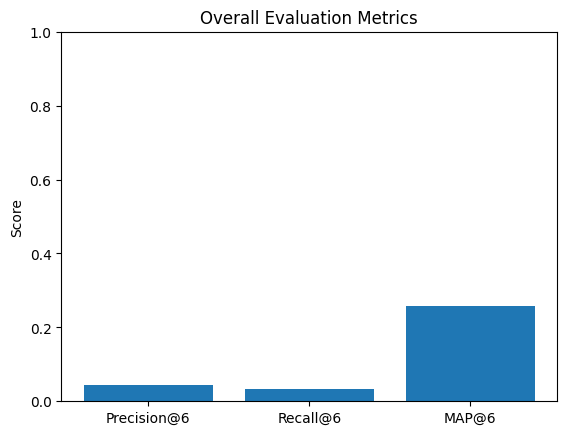

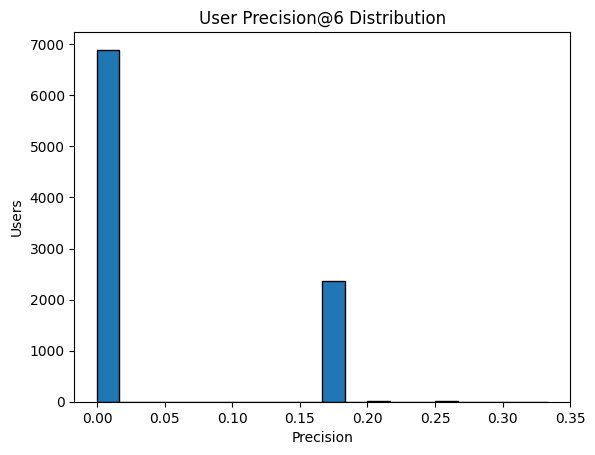

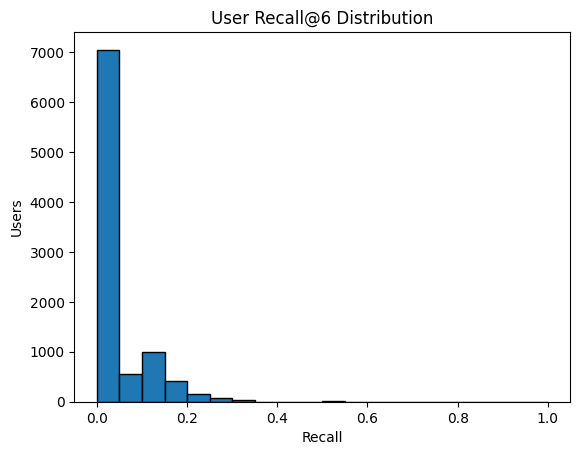

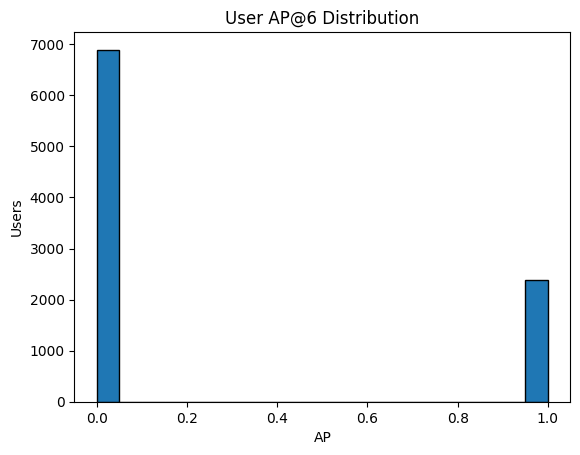

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
metrics_avg = [results[f'Precision@{K}'], results[f'Recall@{K}'], results[f'MAP@{K}']]
labels = [f'Precision@{K}', f'Recall@{K}', f'MAP@{K}']
ax.bar(labels, metrics_avg)
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
ax.set_title("Overall Evaluation Metrics")
plt.show()

if precisions:
    plt.hist(precisions, bins=20, edgecolor="black")
    plt.title(f"User Precision@{K} Distribution")
    plt.xlabel("Precision"); plt.ylabel("Users")
    plt.show()

if recalls:
    plt.hist(recalls, bins=20, edgecolor="black")
    plt.title(f"User Recall@{K} Distribution")
    plt.xlabel("Recall"); plt.ylabel("Users")
    plt.show()

if aps:
    plt.hist(aps, bins=20, edgecolor="black")
    plt.title(f"User AP@{K} Distribution")
    plt.xlabel("AP"); plt.ylabel("Users")
    plt.show()
